# Probabilistic Prediction of PV Generation

## Import Libraries

In [37]:
%reset -s -f
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

from sklearn.model_selection import train_test_split

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.7.0')
pyro.set_rng_seed(1)


# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

## Input Data

In [38]:
generation_file = './Plant_1_Generation_Data.csv'
plant1_gen_data = pd.read_csv(generation_file)
plant1_gen_data['DATE_TIME'] = pd.to_datetime(plant1_gen_data['DATE_TIME'], errors='coerce')
plant1_gen_data = plant1_gen_data.groupby('DATE_TIME')[['DC_POWER','AC_POWER', 'DAILY_YIELD','TOTAL_YIELD']].agg('sum')
plant1_gen_data = plant1_gen_data.reset_index()
plant1_gen_data.tail()

,DATE_TIME,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
3153,2020-12-06 22:45:00,0.0,0.0,127815.000000,155388778.0
3154,2020-12-06 23:00:00,0.0,0.0,127815.000000,155388778.0
3155,2020-12-06 23:15:00,0.0,0.0,127815.000000,155388778.0
3156,2020-12-06 23:30:00,0.0,0.0,127815.000000,155388778.0
3157,2020-12-06 23:45:00,0.0,0.0,115458.196429,155388778.0


In [39]:
plant1_gen_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATE_TIME    3158 non-null   datetime64[ns]
 1   DC_POWER     3158 non-null   float64       
 2   AC_POWER     3158 non-null   float64       
 3   DAILY_YIELD  3158 non-null   float64       
 4   TOTAL_YIELD  3158 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 123.5 KB


In [40]:
weather_file = './Plant_1_Weather_Sensor_Data.csv'
plant1_wea_data = pd.read_csv(weather_file)
plant1_wea_data['DATE_TIME'] = pd.to_datetime(plant1_wea_data['DATE_TIME'], errors='coerce')
plant1_wea_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            3182 non-null   datetime64[ns]
 1   PLANT_ID             3182 non-null   int64         
 2   SOURCE_KEY           3182 non-null   object        
 3   AMBIENT_TEMPERATURE  3182 non-null   float64       
 4   MODULE_TEMPERATURE   3182 non-null   float64       
 5   IRRADIATION          3182 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 149.3+ KB


In [41]:
plant1_wea_data.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
3177,2020-06-17 22:45:00,4135001,HmiyD2TTLFNqkNe,22.150570,21.480377,0.0
3178,2020-06-17 23:00:00,4135001,HmiyD2TTLFNqkNe,22.129816,21.389024,0.0
3179,2020-06-17 23:15:00,4135001,HmiyD2TTLFNqkNe,22.008275,20.709211,0.0
3180,2020-06-17 23:30:00,4135001,HmiyD2TTLFNqkNe,21.969495,20.734963,0.0
3181,2020-06-17 23:45:00,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0


In [42]:
plant1_data = plant1_wea_data.merge(plant1_gen_data, left_on='DATE_TIME', right_on='DATE_TIME')
del plant1_data['PLANT_ID']
del plant1_data['SOURCE_KEY']
del plant1_data['DAILY_YIELD']
del plant1_data['TOTAL_YIELD']
plant1_data = plant1_data.assign(DELTA_TEMPERATURE = abs(plant1_data.MODULE_TEMPERATURE - plant1_data.AMBIENT_TEMPERATURE))
plant1_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 2101
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            2102 non-null   datetime64[ns]
 1   AMBIENT_TEMPERATURE  2102 non-null   float64       
 2   MODULE_TEMPERATURE   2102 non-null   float64       
 3   IRRADIATION          2102 non-null   float64       
 4   DC_POWER             2102 non-null   float64       
 5   AC_POWER             2102 non-null   float64       
 6   DELTA_TEMPERATURE    2102 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 131.4 KB


In [43]:
plant1_data.tail()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DC_POWER,AC_POWER,DELTA_TEMPERATURE
2097,2020-06-17 22:45:00,22.150570,21.480377,0.0,0.0,0.0,0.670192
2098,2020-06-17 23:00:00,22.129816,21.389024,0.0,0.0,0.0,0.740792
2099,2020-06-17 23:15:00,22.008275,20.709211,0.0,0.0,0.0,1.299063
2100,2020-06-17 23:30:00,21.969495,20.734963,0.0,0.0,0.0,1.234532
2101,2020-06-17 23:45:00,21.909288,20.427972,0.0,0.0,0.0,1.481315


In [44]:
input_features = plant1_data[['DELTA_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
pv_generation = plant1_data['DC_POWER']
X_train, X_test, y_train, y_test = train_test_split(input_features, pv_generation, test_size=0.1, shuffle = False)

In [45]:
X_train = torch.tensor(X_train.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float) / 1000
X_test =  torch.tensor(X_test.values, dtype=torch.float)
y_test = torch.tensor(y_test.values, dtype=torch.float) / 1000

In [46]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

torch.Size([1891, 3])
torch.Size([1891])
torch.Size([211, 3])
torch.Size([211])


## Build Model

In [47]:
from torch import nn
from pyro.nn import PyroModule
from pyro.nn import PyroSample
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 10.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 100.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [48]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [49]:
from pyro.infer import SVI, Trace_ELBO


adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [50]:
pyro.clear_param_store()
num_iterations = 200 if not smoke_test else 2
y_train += torch.randn(y_train.shape) * 10
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(X_train, y_train)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(y_train)))

[iteration 0001] loss: 173.1835
[iteration 0101] loss: 12.9427


In [51]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([7.5500, 7.6761, 7.7976]),
 'linear.weight': tensor([[[5.6702, 1.5849, 5.6359]],
 
         [[5.7413, 1.6395, 5.7237]],
 
         [[5.8124, 1.6940, 5.8115]]]),
 'linear.bias': tensor([[-19.7242],
         [-19.6676],
         [-19.6110]])}

In [52]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(X_test)
pred_summary = summary(samples)

In [53]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "DT": X_test[:, 0],
    "MT": X_test[:, 1],
    "IR": X_test[:, 2],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gen": y_test,
})

[Text(0.5, 0, 'Index'),
 Text(0, 0.5, 'PV generation'),
 Text(0.5, 1.0, 'Interval prediction')]

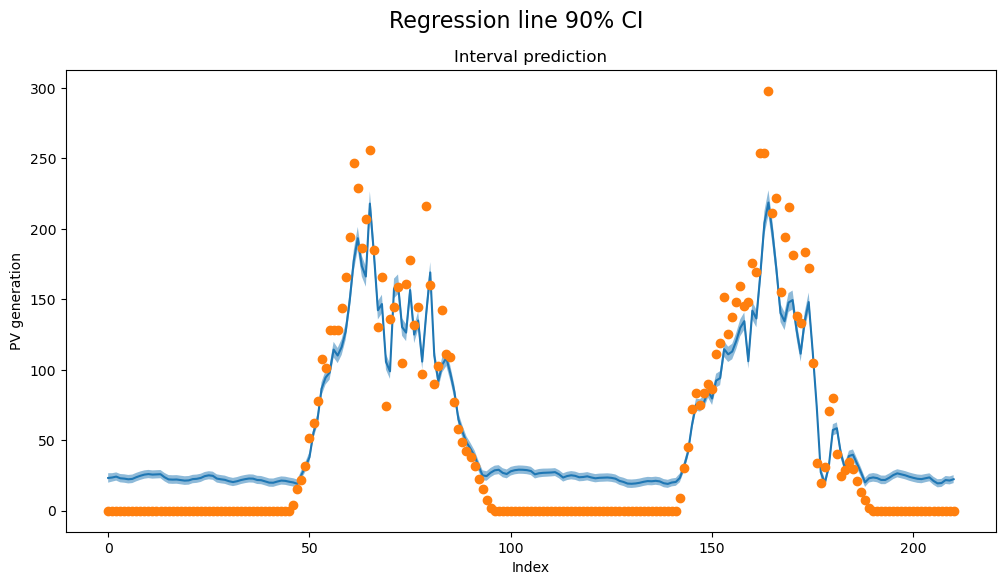

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6), sharey=True)
fig.suptitle("Regression line 90% CI", fontsize=16)
x_array = [i for i in range(len(y_test))]
ax.plot(x_array,
           predictions["mu_mean"])
# ax.plot(x_array,
# [t.item() for t in predictions["mu_perc_5"]])
# ax.plot(x_array,
# [t.item() for t in predictions["mu_perc_95"]])
ax.fill_between(x_array,
                   [t.item() for t in predictions["mu_perc_5"]],
                   [t.item() for t in predictions["mu_perc_95"]],
                   alpha=0.5)
ax.plot(x_array,
           predictions["true_gen"],
           "o")
ax.set(xlabel="Index",
          ylabel="PV generation",
          title="Interval prediction")